##Binary Image classifier using Keras and Convolutional Neural Networks to identify single use plastics (Plastic Bag Vs Plastic Bottle)

### 1. Loading the data and importing the required libraries

Data Set Folder Structure:

> Plastic_data:

      - Plastic Bag:            
            - Train (600 Images)
            - Validation (150 Images)
            - Test (25 Images)
      - Plastic Bottle
            - Train (600 Images)
            - Validation (150 Images)
            - Test (25 Images)

In [1]:
#################### Download and unzip the file from Google Drive ####################

!pip install -U -q PyDrive
#Google Drive Id for the dataset
#https://drive.google.com/open?id=15fJfKUd_BsTZ1Hn0j1RiO70U0kR7t2f3
zip_id = '15fJfKUd_BsTZ1Hn0j1RiO70U0kR7t2f3'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('DATA'):
    os.makedirs('DATA')

# Download zip file
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('Plastic_Data.zip')

# Unzip the downloaded file
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('Plastic_Data.zip', 'r')
zip_ref.extractall('DATA/')
zip_ref.close()

Uncompressing zip file


In [0]:
# Load the required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import keras
import math
from keras.preprocessing import image
import os
import glob
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from keras.models import Sequential
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger
from keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from keras import applications
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models


In [0]:
# Data Loading
training_data_dir = 'DATA/train' 
validation_data_dir = 'DATA/valid' 
test_data_dir = 'DATA/test' 

### 2. Initializing parameters

In [0]:
# Initializing files to save the results
model_summary_file = "model_summary.txt"
test_file = "test_file.txt"
model_file = "model.h5"
fully_connected_weights_path = 'fully_connected_model.h5'

In [0]:
# Hyperparameters
image_size = 200
image_height, image_width = image_size, image_size
epochs = 75
batch_size = 10
num_training_samples = 1200
num_validation_samples = 300
num_test_samples = 50

In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, image_width, image_height)
else:
    input_shape = (image_height, image_width, 3)

### 3. Feature extraction from a pre-trained network - VGG 16 trained on Imagenet dataset

In [58]:
# Build the VGG16 network with imagenet weights
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### 4. Data Augmentation to deal with less data

In [0]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)


### 5. Data Preparation for training  - Loading the data and get features from the pre-trained model (VGG-16)

In [59]:
training_data_generator = train_datagen.flow_from_directory(training_data_dir,
                                                            target_size=(image_width, image_height),
                                                            batch_size=batch_size,
                                                            class_mode=None,
                                                            shuffle=False)
vgg16_features_train = model.predict_generator(training_data_generator, 
                                               1200 // batch_size)
np.save(open('vgg16_features_train.npy', 'wb'),vgg16_features_train)
# save the class indices to use use later in predictions
np.save('class_indices.npy', training_data_generator.class_indices)

validation_data_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                                   target_size=(image_width, image_height),
                                                                   batch_size=batch_size,
                                                                   class_mode=None,
                                                                   shuffle=False)
vgg16_features_validation = model.predict_generator(validation_data_generator, 
                                                    300 // batch_size)
np.save(open('vgg16_features_validation.npy', 'wb'),vgg16_features_validation)

test_data_generator = test_datagen.flow_from_directory(test_data_dir,
                                                              target_size=(image_width, image_height),
                                                              batch_size=batch_size,
                                                              class_mode="binary", 
                                                              shuffle=False)
vgg16_features_test = model.predict_generator(test_data_generator, 
                                                   50 // batch_size)
np.save(open('vgg16_features_test.npy', 'wb'),vgg16_features_test)

Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [0]:
# Load the data pre-trained by VGG 16 model
train_data = np.load(open('vgg16_features_train.npy', 'rb'))
train_labels = np.array([0] * 600 + [1] * 600)

validation_data = np.load(open('vgg16_features_validation.npy', 'rb'))
validation_labels = np.array([0] * 150 + [1] * 150)

test_data = np.load(open('vgg16_features_test.npy', 'rb'))
test_labels = np.array([0] * 25 + [1] * 25)

### 6. Model Training - Train the data with fully connected layers

In [78]:
# Model training
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.SGD(lr=1e-4, decay=1e-4, momentum=0.9),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_data, 
                    train_labels,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))
model.save_weights(fully_connected_weights_path)

Train on 1200 samples, validate on 300 samples
Epoch 1/100
1200/1200 [==============================] - 3s 3ms/step - loss: 0.5892 - acc: 0.7342 - val_loss: 0.2426 - val_acc: 0.8900
Epoch 2/100
1200/1200 [==============================] - 1s 1ms/step - loss: 0.3602 - acc: 0.8425 - val_loss: 0.2046 - val_acc: 0.9167
Epoch 3/100
1200/1200 [==============================] - 1s 1ms/step - loss: 0.2837 - acc: 0.8775 - val_loss: 0.1817 - val_acc: 0.9467
Epoch 4/100
1200/1200 [==============================] - 1s 1ms/step - loss: 0.2732 - acc: 0.8900 - val_loss: 0.1543 - val_acc: 0.9400
Epoch 5/100
1200/1200 [==============================] - 1s 1ms/step - loss: 0.2292 - acc: 0.9067 - val_loss: 0.1507 - val_acc: 0.9467
Epoch 6/100
1200/1200 [==============================] - 1s 1ms/step - loss: 0.2361 - acc: 0.9100 - val_loss: 0.1564 - val_acc: 0.9467
Epoch 7/100
1200/1200 [==============================] - 1s 1ms/step - loss: 0.1903 - acc: 0.9217 - val_loss: 0.1431 - val_acc: 0.9467
Epoch 8/

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               4718848   
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
__________

In [0]:
#Save the Model summary
with open(model_summary_file,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

### 7. Model Performance in training and validation sets

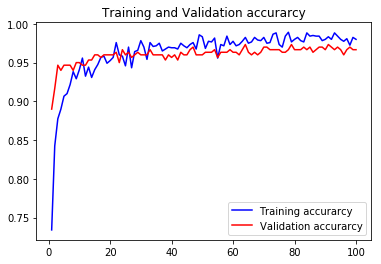

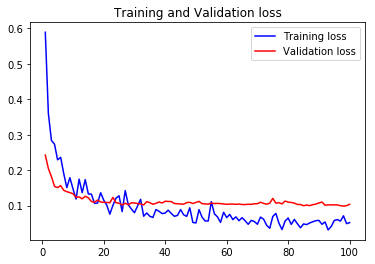

In [81]:
#Get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()



### 8. Model Evaluation on Validation Set

In [82]:
#Confution Matrix and Classification Report for the validation set

test = np.load('vgg16_features_validation.npy')
predictions = model.predict_classes(test)
print('Confusion Matrix - Validation Set:')
print(confusion_matrix(validation_labels, predictions),"\n")
print('Classification Report - Validation Set:')
target_names = ['plastic bag','plastic bottle']
print(classification_report(validation_labels, predictions, target_names=target_names))

Confusion Matrix - Validation Set:
[[144   6]
 [  4 146]] 

Classification Report - Validation Set:
                precision    recall  f1-score   support

   plastic bag       0.97      0.96      0.97       150
plastic bottle       0.96      0.97      0.97       150

     micro avg       0.97      0.97      0.97       300
     macro avg       0.97      0.97      0.97       300
  weighted avg       0.97      0.97      0.97       300



In [83]:
print("Validation Set Accuracy:",accuracy_score(validation_labels, predictions)*100,"%")

Validation Set Accuracy: 96.66666666666667 %


### 9. Make prediction on unseen data

In [0]:
def image_prediction(uploaded):
  for name, data in uploaded.items():
    with open('image1.jpg', 'wb') as f:
      f.write(data)
      f.close()
      print('saved file ' + name)
  return name

def upload_image():
    uploaded = files.upload()
    img = cv2.imread(image_prediction(uploaded))
    img = cv2.resize(img,(200,200))
    img = np.reshape(img,[1,200,200,3])
    
    prediction = model.predict(img)
    if prediction[0][0] == 1:
      pred_class = 'Plastic Bag'
    else:
      pred_class = 'Plastic Bottle'
    print(pred_class)

In [0]:
def prediction_model(bottleneck_prediction):
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights(fully_connected_weights_path)
    return model

DATA/test/Plastic bag/bag (119).jpg


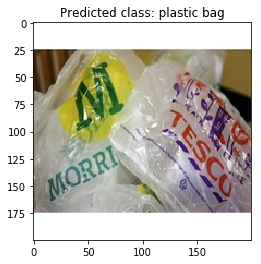

DATA/test/Plastic bag/bag (141).jpg


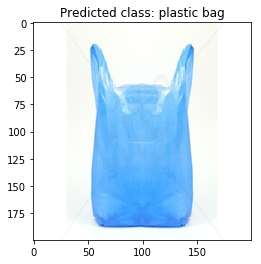

DATA/test/Plastic bag/bag (149).jpg


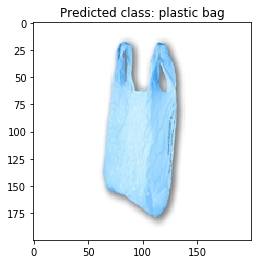

DATA/test/Plastic bag/bag (150).jpg


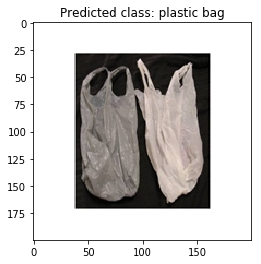

DATA/test/Plastic bag/bag (40).jpg


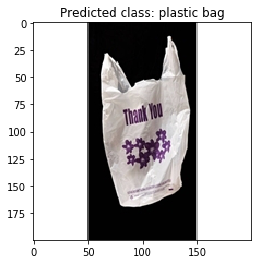

DATA/test/Plastic bag/bag (428).jpg


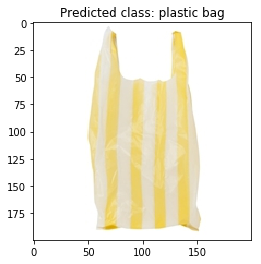

DATA/test/Plastic bag/bag (429).jpg


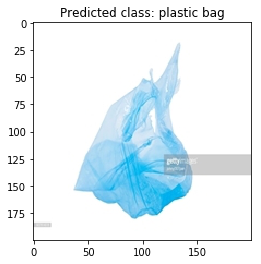

DATA/test/Plastic bag/bag (430).jpg


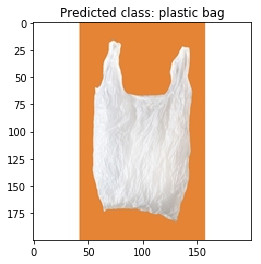

DATA/test/Plastic bag/bag (48).jpg


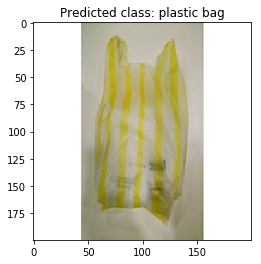

DATA/test/Plastic bag/bag (49).jpg


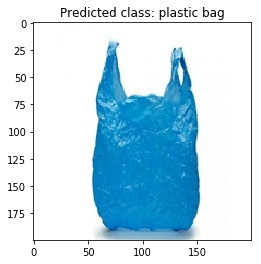

DATA/test/Plastic bag/bag (498).jpg


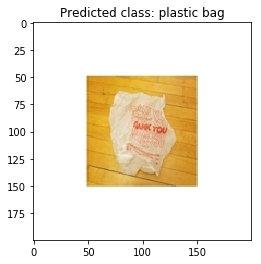

DATA/test/Plastic bag/bag (506).jpg


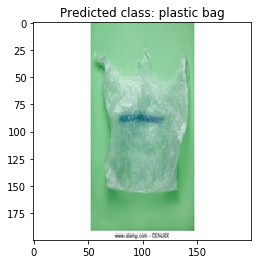

DATA/test/Plastic bag/bag (507).jpg


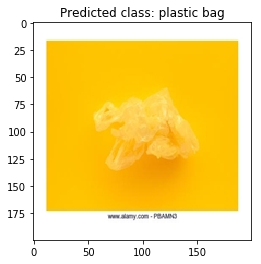

DATA/test/Plastic bag/bag (79).jpg


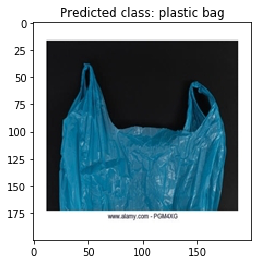

DATA/test/Plastic bag/bag (80).jpg


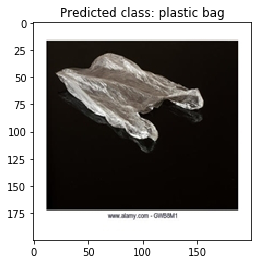

DATA/test/Plastic bag/pic (28).jpg


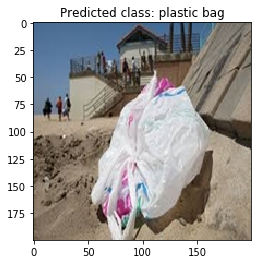

DATA/test/Plastic bag/pic (29).jpg


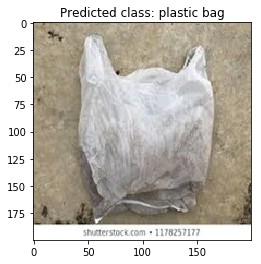

DATA/test/Plastic bag/pic (30).jpg


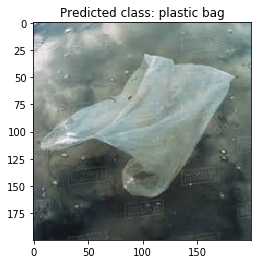

DATA/test/Plastic bag/pic_1100 (1).jpg


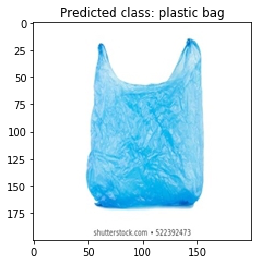

DATA/test/Plastic bag/pic_1106 (4).jpg


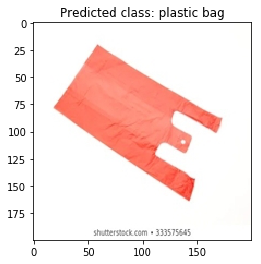

DATA/test/Plastic bag/pic_1111 (2).jpg


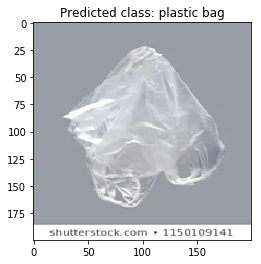

DATA/test/Plastic bag/pic_1111 (3).jpg


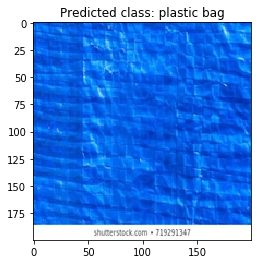

DATA/test/Plastic bag/pic_1111 (4).jpg


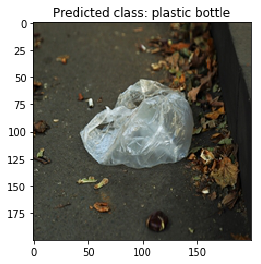

DATA/test/Plastic bag/pic_1117 (2).jpg


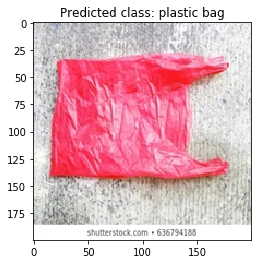

DATA/test/Plastic bag/pic_1117 (3).jpg


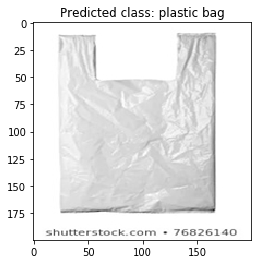

DATA/test/Plastic bottle/bottle (321).jpg


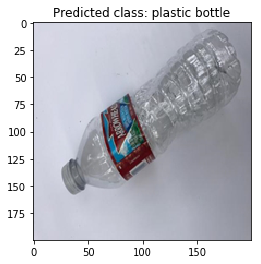

DATA/test/Plastic bottle/bottle (478).jpg


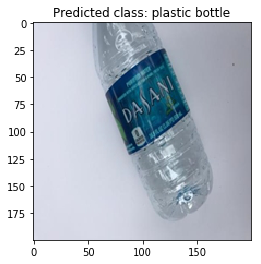

DATA/test/Plastic bottle/bottle (480).jpg


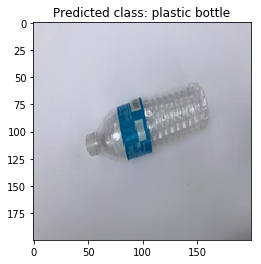

DATA/test/Plastic bottle/pic_1114 (4).jpg


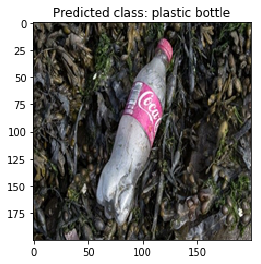

DATA/test/Plastic bottle/pic_1114 (5).jpg


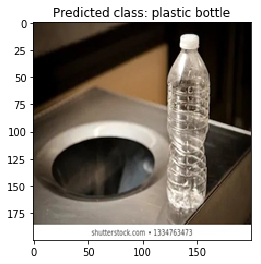

DATA/test/Plastic bottle/pic_1115 (5).jpg


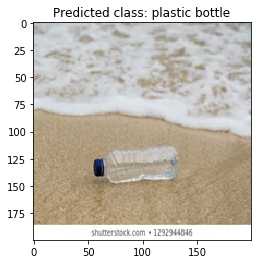

DATA/test/Plastic bottle/pic_1135 (4).jpg


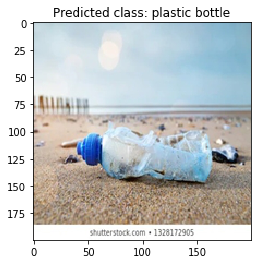

DATA/test/Plastic bottle/pic_1137 (3).jpg


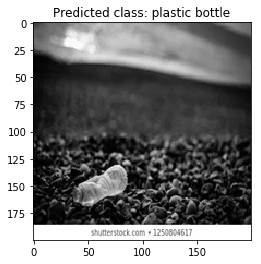

DATA/test/Plastic bottle/pic_1147.jpg


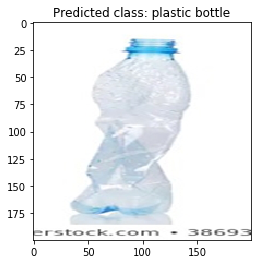

DATA/test/Plastic bottle/pic_1193.jpg


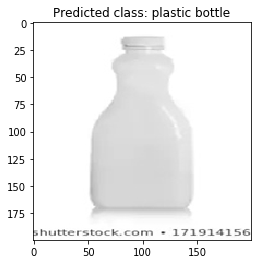

DATA/test/Plastic bottle/pic_1197 (2).jpg


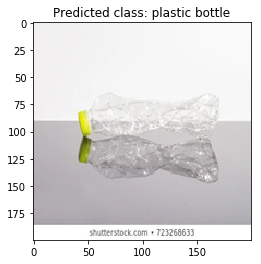

DATA/test/Plastic bottle/pic_1248 (2).jpg


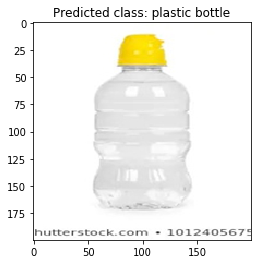

DATA/test/Plastic bottle/pic_1248.jpg


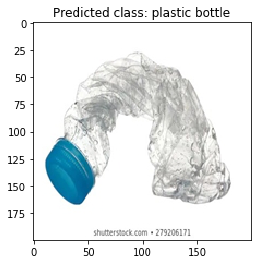

DATA/test/Plastic bottle/pic_1252 (2).jpg


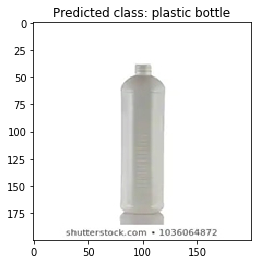

DATA/test/Plastic bottle/pic_1272.jpg


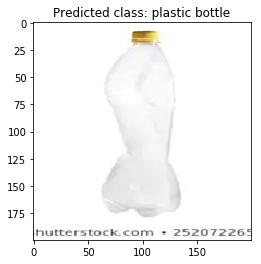

DATA/test/Plastic bottle/pic_1326.jpg


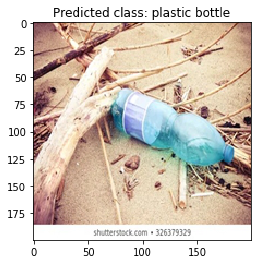

DATA/test/Plastic bottle/pic_1368.jpg


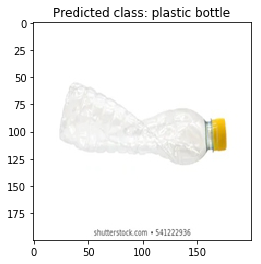

DATA/test/Plastic bottle/pic_1369.jpg


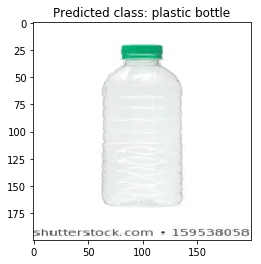

DATA/test/Plastic bottle/pic_1376.jpg


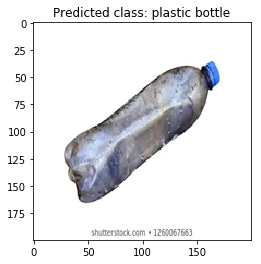

DATA/test/Plastic bottle/pic_1406.jpg


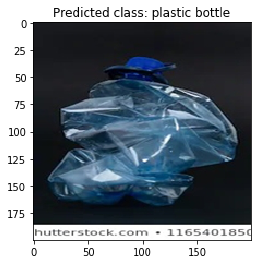

DATA/test/Plastic bottle/pic_1436.jpg


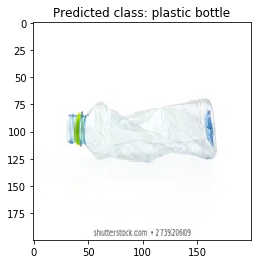

DATA/test/Plastic bottle/pic_1437.jpg


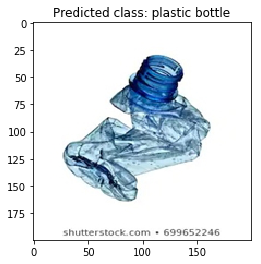

DATA/test/Plastic bottle/pic_1456.jpg


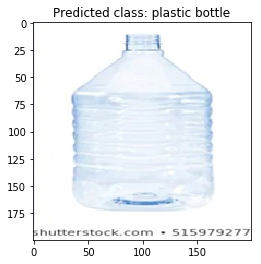

DATA/test/Plastic bottle/pic_1457.jpg


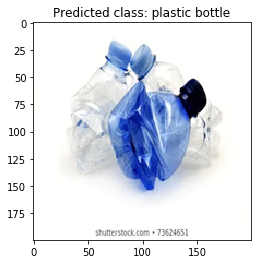

DATA/test/Plastic bottle/pic_1458.jpg


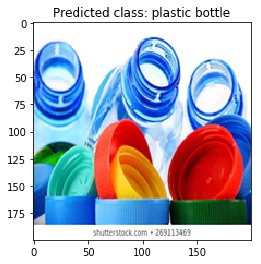

In [89]:
num_of_files = sum([len(files) for r, d, files in os.walk(test_data_dir)])
class_dictionary = np.load('class_indices.npy').item()

# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

preds = []
for index in range(num_of_files):
  image_path = test_data_dir + "/" +test_data_generator.filenames[index]
  print(image_path)
  
  image = load_img(image_path, target_size=(200, 200))
  encoded_img = img_to_array(image)
  encoded_img = encoded_img / 255
  encoded_img = np.expand_dims(encoded_img, axis=0)
  
  # Predict first with the pre-trained model
  bottleneck_prediction = model.predict(encoded_img)
  
  # Predict with the fully fully connected model
  pred_model = prediction_model(bottleneck_prediction)
  class_predicted = pred_model.predict_classes(bottleneck_prediction)
  preds.append(class_predicted)
  if class_predicted[0] == 0:
    plt.title("Predicted class: plastic bag")
  else:
    plt.title("Predicted class: plastic bottle")
  
  plt.imshow(image)
  plt.show()

### 10. Model Evaluation on Test set/Unseen Data

In [90]:
#Evaluation for the test set

from sklearn.metrics import confusion_matrix,accuracy_score

predictions = np.array(preds)
predictions = predictions.reshape(num_of_files,1)
cm = confusion_matrix(test_labels, predictions)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[24  1]
 [ 0 25]]


In [91]:
print("Test Set Accuracy:",accuracy_score(test_labels, predictions)*100,"%")

Test Set Accuracy: 98.0 %
